In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
import wordcloud
import string
import validators
import re
import string
import nltk
import langdetect
from textblob import TextBlob
from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from factor_analyzer.factor_analyzer import FactorAnalyzer
import seaborn as sns
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 100

### All Functions

In [4]:
categories = {"is_media":["media","politics","journalism","journalist","news","reporter","blogger","youtube",\
                          "writer","youtuber","communication","radio","internet","film","television"],  
             "is_education":["educationist","teacher","professor","tutor","pedagogue","scientist","instructor", 
                             "coach","trainer","lecturer","academic","counselor","phd","educator","scholar",
                             "teaching","philosopher","consultant","physician","doctor","education","science",
                             "archaeologist","archaeology","graduate","student","advocate","lawyer","computer",
                             "philanthropist","engineer","engineering","editor","college","university","author",
                            "programming","programmer","doctorate"], 
             "is_politics":["politician","politics","senator","congress","political","archivist","legislatures",
                           "ideology","ideologist"],
             "is_art":["literature","art","artist","actor","music","dance","history","theatre","drama","producer",
                       "director","architect","actress","musician","dancer","design","photographer","storyteller",
                       "poet","decorator","improvisor","culture","humorist"],
             "is_sports":["sports","cricket","tennis","football","basketball","volleyball","cyclist"],
             "is_feminist":["feminist","feminism"]}

def add_category_columns(row):
    desc = row["user_description"]
    if desc is not np.nan:
        desc = desc.lower()
        desc = re.sub(r'[^A-Za-z]',' ',desc).strip()
        desc = re.sub('#', '', desc)                      
        desc = re.sub('https?:\/\/\S+', '', desc)  
        desc = desc.split()
        for c in categories:
            row[c] = 0
            if len(list(set(categories[c])&set(desc))) > 0:
                row[c] = 1
    return row

def get_retweet_count(user,retweet_users):
    retweet_count = 0
    if user in retweet_users:
        retweet_count = retweet_users[user]
    return retweet_count
        
def get_retweets(source_df,dest_df):
    retweet_user_list = []
    for t in source_df[source_df["is_retweet"]==1]["Text"]:
        retweet_user_list.append(t.split(" ")[1].replace("@","").replace(":",""))
    retweet_users = dict(Counter(retweet_user_list))    
    dest_df["retweet_count"] = dest_df.apply(lambda x : get_retweet_count(x["name"],retweet_users),axis=1)
    return dest_df,retweet_users

def mention_names(df,retweet_list):
    mention_screen_names = []
    for i in list(df["user_mention_screen_name"]):
        try:
            i = i.split(";")
            for x in i:
                if x not in retweet_list:
                    mention_screen_names.append(x)
        except Exception as e:
            pass
    return mention_screen_names

def mention_counts(user,mentions):
    mention_count = 0
    if user in mentions:
        mention_count = mentions[user]
    return mention_count


def get_mentions(source_df,dest_df,retweet_list):
    mentions = Counter(mention_names(source_df,retweet_list))
    dest_df["mention_count"] = dest_df.apply(lambda x : mention_counts(x["name"],mentions),axis=1)
    return dest_df

def detect_bio_lang(row):
    text = row["user_description"]
    row["bio_language"] = "NA"
    try:
        if text is not np.nan or len(text) > 2: 
            row["bio_language"] = langdetect.detect(text)
    except Exception as e:
        pass
    return row

def get_all_users(df):
    user_details = {}
    for i,j in df[["from_user","user_description"]].values:
        if i not in user_details:
            user_details[i] = j
    user_details = pd.DataFrame(user_details.items(), columns=["from_user", "user_description"])
    return user_details


def get_tweet_counts(source_df,dest_df):
    tweet_counts = source_df.groupby("from_user")["Text"].count().reset_index()
    tweet_counts.columns = ["from_user","tweets_count"]
    dest_df = pd.merge(dest_df,tweet_counts[tweet_counts["from_user"].isin(dest_df["from_user"])],how="left",on="from_user")
    return dest_df

def add_category_columns_tweets(row):
    desc = row["Text"]
    if desc is not np.nan:
        desc = desc.lower()
        desc = re.sub(r'[^A-Za-z]',' ',desc).strip()
        desc = re.sub('#', '', desc)                      
        desc = re.sub('https?:\/\/\S+', '', desc)  
        desc = desc.split()
        for c in categories:
            row[c] = 0
            if len(list(set(categories[c])&set(desc))) > 0:
                row[c] = 1
    return row

def transform_columns(csv_file):
    df = csv_file   
    df = df.drop(["created_at","from_user","user_description","movement_in","name"],axis=1)
    df["bio_language"] = df["bio_language"].fillna("NA")
    df["followers_count"] = df["followers_count"].fillna(0)
    df["tweets_count"] = df["tweets_count"].fillna(0)
    df["retweet_count"] = df["retweet_count"].fillna(0)
    #df["tweets_count"] = df["tweets_count"].fillna(0)
    df["mention_count"] = df["mention_count"].fillna(0)
    df["is_art"] = df["is_art"].fillna(0)
    df["is_education"] = df["is_education"].fillna(0)
    df["is_feminist"] = df["is_feminist"].fillna(0)
    df["is_media"] = df["is_media"].fillna(0)
    df["is_politics"] = df["is_politics"].fillna(0)
    df["is_sports"] = df["is_sports"].fillna(0)
    df["positive"] = df["positive"].fillna(0)
    df["negative"] = df["negative"].fillna(0)
    df["neutral"] = df["neutral"].fillna(0)
    df["education_content_count"] = df["education_content_count"].fillna(0)
    df["media_content_count"] = df["media_content_count"].fillna(0)
    df["politics_content_count"] = df["politics_content_count"].fillna(0)
    
    lb_make = LabelEncoder()
    df["bio_language"] = lb_make.fit_transform(df["bio_language"])
    df["macro_micro"] = lb_make.fit_transform(df["macro_micro"])
    #df["name"] = lb_make.fit_transform(df["name"])
    return df

  
def calculate_vif_(X, thresh=50):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

In [9]:
mac_mic = glob.glob("./Data/*.csv")
i_sb = pd.DataFrame()
i_gw = pd.DataFrame()
i_wm = pd.DataFrame()
i_mc = pd.DataFrame()

for i in mac_mic:
    movement = i.split("/")[2].split(".")[0].split("_")[2]
    if movement == "sb":
        i_sb = pd.read_csv(i)
        i_sb["movement_in"] = "StopTheBan"
        print(i_sb.shape)
    elif movement == "gw":
        i_gw = pd.read_csv(i)
        i_gw["movement_in"] = "GrabYourWallet"
        print(i_gw.shape)
    elif movement == "wm":
        i_wm = pd.read_csv(i)
        i_wm["movement_in"] = "WhyIMarch"
        print(i_wm.shape)
    else:
        i_mc = pd.read_csv(i)
        i_mc["movement_in"] = "McStrike"
        print(i_mc.shape)

(10478, 4)
(3111, 4)
(11484, 4)
(27331, 4)


### Basic Cleaning

In [10]:
dataM1 = glob.glob("./Data/20170122 WhyIMarch/*.csv")
dataM2 = glob.glob("./Data/20170204 GrabYourWallet/*.csv")
dataM3 = glob.glob("./Data/20190521 StoptheBan/*.csv")
dataM4 = glob.glob("./Data/McStrike/*.csv")

M1 = pd.DataFrame()
for d in dataM1:
    M1 = pd.concat([M1,pd.read_csv(d)])

M2 = pd.DataFrame()
for d in dataM2:
    M2 = pd.concat([M2,pd.read_csv(d)])
    
M3 = pd.DataFrame()
for d in dataM3:
    M3 = pd.concat([M3,pd.read_csv(d)])
    
M4 = pd.DataFrame()
for d in dataM4:
    M4 = pd.concat([M4,pd.read_csv(d)])    
    
M1.columns = [x.replace("[M] ","").replace(": ","") for x in M1.columns] 
M2.columns = [x.replace("[M] ","").replace(": ","") for x in M2.columns] 
M3.columns = [x.replace("[M] ","").replace(": ","") for x in M3.columns] 
M4.columns = [x.replace("[M] ","").replace(": ","") for x in M4.columns] 

M1["followers_count"] = M1["followers_count"].fillna(0)
M2["followers_count"] = M2["followers_count"].fillna(0)
M3["followers_count"] = M3["followers_count"].fillna(0)

M1["favourites_count"] = M1["favourites_count"].fillna(0)
M2["favourites_count"] = M2["favourites_count"].fillna(0)
M3["favourites_count"] = M3["favourites_count"].fillna(0)

M1["friends_count"] = M1["friends_count"].fillna(0)
M2["friends_count"] = M2["friends_count"].fillna(0)
M3["friends_count"] = M3["friends_count"].fillna(0)

M1["username"] = M1["username"].fillna("NA")
M2["username"] = M2["username"].fillna("NA")
M3["username"] = M3["username"].fillna("NA")

M1["hashtag"] = M1["hashtag"].fillna("NA")
M2["hashtag"] = M2["hashtag"].fillna("NA")                                   
M3["hashtag"] = M3["hashtag"].fillna("NA")

M1["movement_name"] = "WhyIMarch"
M2["movement_name"] = "GrabYourWallet"
M3["movement_name"] = "StopTheBan"
M4["movement_name"] = "McStrike"

M1["created_at"] =  pd.to_datetime(M1["created_at"], format='%Y-%m-%d %H:%M:%S')
M2["created_at"] =  pd.to_datetime(M2["created_at"], format='%Y-%m-%d %H:%M:%S')
M3["created_at"] =  pd.to_datetime(M3["created_at"], format='%Y-%m-%d %H:%M:%S')
M4["created_at"] =  pd.to_datetime(M4["created_at"], format='%Y-%m-%d %H:%M:%S')

M1["is_retweet"] = 0
M1.loc[M1["Text"].str.contains("^RT"),"is_retweet"] = 1
M2["is_retweet"] = 0
M2.loc[M2["Text"].str.contains("^RT"),"is_retweet"] = 1
M3["is_retweet"] = 0
M3.loc[M3["Text"].str.contains("^RT"),"is_retweet"] = 1
M4["is_retweet"] = 0
M4.loc[M4["Text"].str.contains("^RT"),"is_retweet"] = 1

In [11]:
print("WhyIMarch :- ",M1.shape)
print("GrabYourWallet :- ",M2.shape)
print("StopTheBan :- ",M3.shape)
print("McStrike :- ",M4.shape)

WhyIMarch :-  (90288, 32)
GrabYourWallet :-  (42403, 34)
StopTheBan :-  (99343, 35)
McStrike :-  (597065, 35)


In [12]:
print(set(list(M2.columns)).difference(set(list(M1.columns))),\
      set(list(M3.columns)).difference(set(list(M1.columns))),\
set(list(M4.columns)).difference(set(list(M1.columns))))

{'ReferenceText', 'Annotations'} {'tweet_id', 'statuses_count', 'profile_image_url'} {'tweet_id', 'statuses_count', 'profile_image_url'}


### Get all unique users

In [13]:
M1_users = get_all_users(M1)
print("Unique users in WhyIMarch :- ",M1_users.shape)
M2_users = get_all_users(M2)
print("Unique users in GrabYourWallet :- ",M2_users.shape)
M3_users = get_all_users(M3)
print("Unique users in StopTheBan :- ",M3_users.shape)
M4_users = get_all_users(M4)
print("Unique users in McStrike :- ",M4_users.shape)

Unique users in WhyIMarch :-  (70163, 2)
Unique users in GrabYourWallet :-  (21607, 2)
Unique users in StopTheBan :-  (56583, 2)
Unique users in McStrike :-  (229369, 2)


In [14]:
print("Number of influencers_WM  :- ",len(set(i_wm["name"])))
print("Number of influencers_GW  :- ",len(set(i_gw["name"])))
print("Number of influencers_SB  :- ",len(set(i_sb["name"])))
print("Number of influencers_MC  :- ",len(set(i_mc["name"])))
print("\n")
print("Number of influencers_WM with description :- ",len(set(i_wm["name"])&(set(M1_users["from_user"]))))
print("Number of influencers_GW with description :- ",len(set(i_gw["name"])&(set(M2_users["from_user"]))))
print("Number of influencers_SB with description :- ",len(set(i_sb["name"])&(set(M3_users["from_user"]))))
print("Number of influencers_MC with description :- ",len(set(i_mc["name"])&(set(M4_users["from_user"]))))

Number of influencers_WM  :-  11484
Number of influencers_GW  :-  3111
Number of influencers_SB  :-  10478
Number of influencers_MC  :-  27331


Number of influencers_WM with description :-  10885
Number of influencers_GW with description :-  2924
Number of influencers_SB with description :-  10187
Number of influencers_MC with description :-  26302


In [15]:
10885 + 2924 + 10187 + 26302, 11484 + 3111 + 10478 + 27331

(50298, 52404)

### Take influencers data from every movement

In [16]:
M1_users = pd.merge(i_wm,M1_users,right_on="from_user",left_on="name",how="left")
M2_users = pd.merge(i_gw,M2_users,right_on="from_user",left_on="name",how="left")
M3_users = pd.merge(i_sb,M3_users,right_on="from_user",left_on="name",how="left")
M4_users = pd.merge(i_mc,M4_users,right_on="from_user",left_on="name",how="left")
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 6) (3111, 6) (10478, 6) (27331, 6)


### Get latest followers count

In [17]:
M1_users = pd.merge(M1_users,M1.loc[M1["from_user"].isin(M1_users["from_user"])].sort_values("created_at").groupby("from_user").last().reset_index()[["from_user","created_at","followers_count"]],how="left")
M2_users = pd.merge(M2_users,M2.loc[M2["from_user"].isin(M2_users["from_user"])].sort_values("created_at").groupby("from_user").last().reset_index()[["from_user","created_at","followers_count"]],how="left")
M3_users = pd.merge(M3_users,M3.loc[M3["from_user"].isin(M3_users["from_user"])].sort_values("created_at").groupby("from_user").last().reset_index()[["from_user","created_at","followers_count"]],how="left")
M4_users = pd.merge(M4_users,M4.loc[M4["from_user"].isin(M4_users["from_user"])].sort_values("created_at").groupby("from_user").last().reset_index()[["from_user","created_at","followers_count"]],how="left")
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 8) (3111, 8) (10478, 8) (27331, 8)


### Add category columns

In [18]:
M1_users = M1_users.apply(add_category_columns,axis=1)
M2_users = M2_users.apply(add_category_columns,axis=1)
M3_users = M3_users.apply(add_category_columns,axis=1)
M4_users = M4_users.apply(add_category_columns,axis=1)
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 14) (3111, 14) (10478, 14) (27331, 14)


### Get number of times retweeted

In [19]:
M1_users,M1_retweets = get_retweets(M1,M1_users)
M2_users,M2_retweets = get_retweets(M2,M2_users)
M3_users,M3_retweets = get_retweets(M3,M3_users)
M4_users,M4_retweets = get_retweets(M4,M4_users)
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 15) (3111, 15) (10478, 15) (27331, 15)


### Get number of times mentioned

In [20]:
M1_users = get_mentions(M1,M1_users,M1_retweets)
M2_users = get_mentions(M2,M2_users,M2_retweets)
M3_users = get_mentions(M3,M3_users,M3_retweets)
M4_users = get_mentions(M4,M4_users,M4_retweets)
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 16) (3111, 16) (10478, 16) (27331, 16)


### Get tweets count

In [21]:
M1_users = get_tweet_counts(M1,M1_users)
M2_users = get_tweet_counts(M2,M2_users)
M3_users = get_tweet_counts(M3,M3_users)
M4_users = get_tweet_counts(M4,M4_users)
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 17) (3111, 17) (10478, 17) (27331, 17)


In [22]:
M1_users.to_csv("./M1_users.csv",index=False)
M2_users.to_csv("./M2_users.csv",index=False)
M3_users.to_csv("./M3_users.csv",index=False)
M4_users.to_csv("./M4_users.csv",index=False)

### Get bio language

In [23]:
%time M1_users = M1_users.apply(detect_bio_lang,axis=1)

CPU times: user 55 s, sys: 464 ms, total: 55.4 s
Wall time: 55.8 s


In [24]:
%time M2_users = M2_users.apply(detect_bio_lang,axis=1)

CPU times: user 13.6 s, sys: 112 ms, total: 13.7 s
Wall time: 13.7 s


In [25]:
%time M3_users = M3_users.apply(detect_bio_lang,axis=1)

CPU times: user 47.9 s, sys: 400 ms, total: 48.3 s
Wall time: 48.3 s


In [26]:
%time M4_users = M4_users.apply(detect_bio_lang,axis=1)

CPU times: user 2min 7s, sys: 988 ms, total: 2min 8s
Wall time: 2min 8s


In [31]:
len(M1_users["bio_language"].unique()),len(M2_users["bio_language"].unique()),len(M3_users["bio_language"].unique()),len(M4_users["bio_language"].unique())

(44, 31, 40, 51)

In [41]:
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 18) (3111, 18) (10478, 18) (27331, 18)


In [42]:
def cleanText(text):
    if len(text) > 2 or text is not np.nan:
        text = re.sub('RT[\s]+', '', text)                # Removing RT
        text = re.sub('@[A-Za-z0–9]+', '', text)          # Removing @mentions
        text = re.sub('#', '', text)                      # Removing '#' hash tag
        text = re.sub('https?:\/\/\S+', '', text)         # Removing hyperlink
        for i in text:
            if i not in string.printable[0:62]:
                text = text.replace(i," ")
    return text

In [43]:
def get_tweet_sentiment(tweet):
    try:
        analysis = TextBlob(cleanText(tweet)) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'
    except Exception as e:
        print(e)
        return "NA"


In [44]:
sample = shuffle(M1).head()

In [45]:
%time M1["tweet_sentiment"] = M1.apply(lambda s : get_tweet_sentiment(s["Text"]),axis = 1)

CPU times: user 35.9 s, sys: 15.8 ms, total: 35.9 s
Wall time: 35.9 s


In [46]:
%time M2["tweet_sentiment"] = M2.apply(lambda s : get_tweet_sentiment(s["Text"]),axis = 1)

CPU times: user 18.3 s, sys: 24 ms, total: 18.4 s
Wall time: 18.4 s


In [47]:
%time M3["tweet_sentiment"] = M3.apply(lambda s : get_tweet_sentiment(s["Text"]),axis = 1)

CPU times: user 46.2 s, sys: 204 ms, total: 46.4 s
Wall time: 46.4 s


In [48]:
%time M4["tweet_sentiment"] = M4.apply(lambda s : get_tweet_sentiment(s["Text"]),axis = 1)

CPU times: user 4min 43s, sys: 502 ms, total: 4min 43s
Wall time: 4min 43s


In [49]:
print(M1["tweet_sentiment"].value_counts())
print(M2["tweet_sentiment"].value_counts())
print(M3["tweet_sentiment"].value_counts())
print(M4["tweet_sentiment"].value_counts())

neutral     50146
positive    27706
negative    12436
Name: tweet_sentiment, dtype: int64
neutral     25800
positive    13107
negative     3496
Name: tweet_sentiment, dtype: int64
positive    43820
neutral     42070
negative    13453
Name: tweet_sentiment, dtype: int64
neutral     313824
positive    209872
negative     73369
Name: tweet_sentiment, dtype: int64


In [50]:
M1_sentiment = pd.pivot_table(M1[["from_user","tweet_sentiment"]],index = "from_user", columns = "tweet_sentiment", aggfunc=len).fillna(0)
M2_sentiment = pd.pivot_table(M2[["from_user","tweet_sentiment"]],index = "from_user", columns = "tweet_sentiment", aggfunc=len).fillna(0)
M3_sentiment = pd.pivot_table(M3[["from_user","tweet_sentiment"]],index = "from_user", columns = "tweet_sentiment", aggfunc=len).fillna(0)
M4_sentiment = pd.pivot_table(M4[["from_user","tweet_sentiment"]],index = "from_user", columns = "tweet_sentiment", aggfunc=len).fillna(0)

In [51]:
M1_users = pd.merge(M1_users,M1_sentiment,left_on="from_user",right_on="from_user",how="left")
M2_users = pd.merge(M2_users,M2_sentiment,left_on="from_user",right_on="from_user",how="left")
M3_users = pd.merge(M3_users,M3_sentiment,left_on="from_user",right_on="from_user",how="left")
M4_users = pd.merge(M4_users,M4_sentiment,left_on="from_user",right_on="from_user",how="left")
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 21) (3111, 21) (10478, 21) (27331, 21)


In [52]:
M1_users.columns

Index(['community', 'created_at', 'followers_count', 'from_user', 'is_art',
       'is_education', 'is_feminist', 'is_media', 'is_politics', 'is_sports',
       'macro_micro', 'movement_in', 'name', 'user_description',
       'retweet_count', 'mention_count', 'tweets_count', 'bio_language',
       'negative', 'neutral', 'positive'],
      dtype='object')

### Tweet content count

In [53]:
%time M1 = M1.apply(add_category_columns_tweets,axis=1)

CPU times: user 5min 50s, sys: 404 ms, total: 5min 50s
Wall time: 5min 50s


In [54]:
%time M2 = M2.apply(add_category_columns_tweets,axis=1)

CPU times: user 2min 43s, sys: 72 ms, total: 2min 43s
Wall time: 2min 43s


In [55]:
%time M3 = M3.apply(add_category_columns_tweets,axis=1)

CPU times: user 6min 21s, sys: 272 ms, total: 6min 21s
Wall time: 6min 21s


In [56]:
%time M4 = M4.apply(add_category_columns_tweets,axis=1)
print(M1.shape,M2.shape,M3.shape,M4.shape)

CPU times: user 38min 35s, sys: 3.56 s, total: 38min 38s
Wall time: 38min 38s
(90288, 39) (42403, 41) (99343, 42) (597065, 42)


In [57]:
tweet_content_M1 = pd.DataFrame(M1[["from_user","is_education","is_media","is_politics"]].groupby("from_user").sum().reset_index())
tweet_content_M1 = tweet_content_M1.rename(columns={"is_education": "education_content_count", "is_media": "media_content_count","is_politics":"politics_content_count"})
tweet_content_M2 = pd.DataFrame(M2[["from_user","is_education","is_media","is_politics"]].groupby("from_user").sum().reset_index())
tweet_content_M2 = tweet_content_M2.rename(columns={"is_education": "education_content_count", "is_media": "media_content_count","is_politics":"politics_content_count"})
tweet_content_M3 = pd.DataFrame(M3[["from_user","is_education","is_media","is_politics"]].groupby("from_user").sum().reset_index())
tweet_content_M3 = tweet_content_M3.rename(columns={"is_education": "education_content_count", "is_media": "media_content_count","is_politics":"politics_content_count"})
tweet_content_M4 = pd.DataFrame(M4[["from_user","is_education","is_media","is_politics"]].groupby("from_user").sum().reset_index())
tweet_content_M4 = tweet_content_M4.rename(columns={"is_education": "education_content_count", "is_media": "media_content_count","is_politics":"politics_content_count"})

M1_users = pd.merge(tweet_content_M1,M1_users,left_on="from_user",right_on="from_user",how="right")
M2_users = pd.merge(tweet_content_M2,M2_users,left_on="from_user",right_on="from_user",how="right")
M3_users = pd.merge(tweet_content_M3,M3_users,left_on="from_user",right_on="from_user",how="right")
M4_users = pd.merge(tweet_content_M4,M4_users,left_on="from_user",right_on="from_user",how="right")
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 24) (3111, 24) (10478, 24) (27331, 24)


In [59]:
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 24) (3111, 24) (10478, 24) (27331, 24)


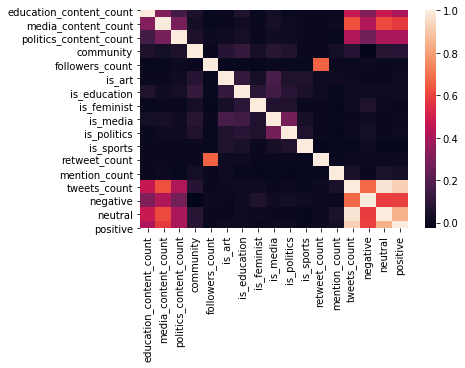

In [15]:
sns.heatmap(M1_users.corr())

In [ ]:
sns.heatmap(M2_users.corr())

In [ ]:
sns.heatmap(M3_users.corr())

In [ ]:
sns.heatmap(M4_users.corr())

In [ ]:
M1_users.groupby(['macro_micro','is_education']).size().reset_index().pivot_table(columns='is_education', index='macro_micro', values=0).plot(kind = 'bar',stacked = True),

In [ ]:
M1_users.groupby(['macro_micro','is_education','is_media','is_politics','is_art','is_sports','is_feminist']).size().reset_index()

In [58]:
M1_users.columns

Index(['from_user', 'education_content_count', 'media_content_count',
       'politics_content_count', 'community', 'created_at', 'followers_count',
       'is_art', 'is_education', 'is_feminist', 'is_media', 'is_politics',
       'is_sports', 'macro_micro', 'movement_in', 'name', 'user_description',
       'retweet_count', 'mention_count', 'tweets_count', 'bio_language',
       'negative', 'neutral', 'positive'],
      dtype='object')

In [5]:
M1_final_users = transform_columns(M1_users)
M2_final_users = transform_columns(M2_users)
M3_final_users = transform_columns(M3_users)
M4_final_users = transform_columns(M4_users)

In [6]:
M1_f = calculate_vif_(M1_final_users)
M2_f = calculate_vif_(M2_final_users)
M3_f = calculate_vif_(M3_final_users)
M4_f = calculate_vif_(M4_final_users)

dropping 'negative' at index: 14
dropping 'tweets_count' at index: 17
Remaining variables:
Index(['education_content_count', 'media_content_count',
       'politics_content_count', 'bio_language', 'community',
       'followers_count', 'is_art', 'is_education', 'is_feminist', 'is_media',
       'is_politics', 'is_sports', 'macro_micro', 'mention_count', 'neutral',
       'positive', 'retweet_count'],
      dtype='object')
dropping 'negative' at index: 14
dropping 'tweets_count' at index: 17
Remaining variables:
Index(['education_content_count', 'media_content_count',
       'politics_content_count', 'bio_language', 'community',
       'followers_count', 'is_art', 'is_education', 'is_feminist', 'is_media',
       'is_politics', 'is_sports', 'macro_micro', 'mention_count', 'neutral',
       'positive', 'retweet_count'],
      dtype='object')
dropping 'negative' at index: 14
dropping 'tweets_count' at index: 17
Remaining variables:
Index(['education_content_count', 'media_content_count',


In [7]:
# Bartlett’s test of sphericity checks whether or not the observed variables 
# intercorrelate at all using the observed correlation matrix against the identity matrix. 
# If the test found statistically insignificant, you should not employ a factor analysis.
from factor_analyzer import factor_analyzer

chi_square_value_M1,p_value_M1 = factor_analyzer.calculate_bartlett_sphericity(M1_f)
print(chi_square_value_M1,p_value_M1)
chi_square_value_M2,p_value_M2 = factor_analyzer.calculate_bartlett_sphericity(M2_f)
print(chi_square_value_M2,p_value_M2)
chi_square_value_M3,p_value_M3 = factor_analyzer.calculate_bartlett_sphericity(M3_f)
print(chi_square_value_M3,p_value_M3)
chi_square_value_M4,p_value_M4 = factor_analyzer.calculate_bartlett_sphericity(M4_f)
print(chi_square_value_M4,p_value_M4)

42124.942231949535 0.0
6496.213509248579 0.0
24535.493186265394 0.0
100899.73664962902 0.0


In [8]:
# Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. 
# It determines the adequacy for each observed variable and for the complete model. 
# KMO estimates the proportion of variance among all the observed variable. 
# Lower proportion id more suitable for factor analysis. 
# KMO values range between 0 and 1. 
# Value of KMO less than 0.6 is considered inadequate.

from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all_M1,kmo_model_M1 = calculate_kmo(M1_f)
print(kmo_model_M1)
kmo_all_M2,kmo_model_M2 = calculate_kmo(M2_f)
print(kmo_model_M2)
kmo_all_M3,kmo_model_M3 = calculate_kmo(M3_f)
print(kmo_model_M3)
kmo_all_M4,kmo_model_M4 = calculate_kmo(M4_f)
print(kmo_model_M4)

0.6740137792926608
0.6198005685181508
0.6817274547081452
0.62956003657593


In [9]:
def plot_scree(df,title): 
    fa = FactorAnalyzer()
    fa.fit(df)
    eigen_values, vectors = fa.get_eigenvalues()
    plt.scatter(range(1,df.shape[1]+1),eigen_values)
    plt.plot(range(1,df.shape[1]+1),eigen_values)
    plt.title('Scree Plot for '+title)
    plt.xlabel('Factors')
    plt.ylabel('Eigenvalue')
    plt.grid()
    plt.show()
    return

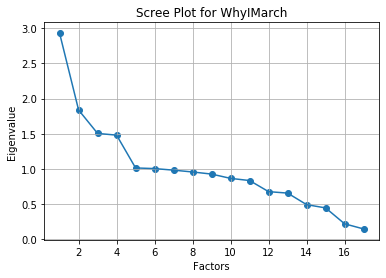

In [10]:
plot_scree(M1_f,"WhyIMarch")

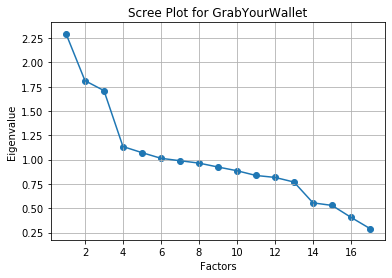

In [11]:
plot_scree(M2_f,"GrabYourWallet")

In [12]:
def factor_analysis(df,n_factors):
    # Create factor analysis object and perform factor analysis
    # Kaiser test choose features with eigenvalues greater than 1
#     fa = FactorAnalyzer()
#     fa.fit(df)
#     eigen_values, vectors = fa.get_eigenvalues()
    
    fa = FactorAnalyzer()
    fa.set_params(n_factors = n_factors, rotation = "promax")
    fa.fit(df)
    loadings = fa.loadings_
    #print(fa.get_factor_variance())
    loadings = pd.DataFrame(loadings)
    loadings.index = list(df.columns)
    columns = []
    for i in range(n_factors):
        columns.append(("Factor"+str(i)))
    loadings.columns = columns
    return loadings


# M1_loadings.to_csv("./M1_loadings_4.csv")
# M2_loadings.to_csv("./M2_loadings_4.csv")
# M3_loadings.to_csv("./M3_loadings_4.csv")
# M4_loadings.to_csv("./M4_loadings_4.csv")
# M1_loadings = factor_analysis(M1_f)
# print(M1_loadings)
# M2_loadings = factor_analysis(M2_f)
# print(M2_loadings)
# M3_loadings = factor_analysis(M3_f)
# print(M3_loadings)
# M4_loadings = factor_analysis(M4_f)
# print(M4_loadings)


### 4 for M1,M4 3 for M2,M3

In [13]:
M1_loadings = factor_analysis(M1_f,4)
print(M1_loadings)
M2_loadings = factor_analysis(M2_f,3)
print(M2_loadings)
M3_loadings = factor_analysis(M3_f,3)
print(M3_loadings)
M4_loadings = factor_analysis(M4_f,4)
print(M4_loadings)

                          Factor0   Factor1   Factor2   Factor3
education_content_count  0.477844 -0.003595  0.001676  0.013792
media_content_count      0.657857 -0.060046  0.003507  0.003195
politics_content_count   0.433374 -0.025234  0.002915  0.014220
bio_language             0.017068 -0.106663 -0.011931  0.067990
community               -0.060547  0.968997 -0.034255  0.158411
followers_count          0.004031 -0.006945  0.506221  0.011468
is_art                   0.001185  0.019745  0.006404  0.294957
is_education             0.010805  0.050960  0.006645  0.294814
is_feminist             -0.001747  0.007740 -0.000511  0.158796
is_media                -0.006287 -0.001117  0.012506  0.628059
is_politics             -0.008145  0.016682  0.007261  0.406101
is_sports               -0.004744 -0.012463 -0.002355  0.119102
macro_micro             -0.021362  0.808556 -0.027598  0.162962
mention_count            0.031494  0.023868 -0.000847 -0.001831
neutral                  0.969340 -0.059

In [15]:
M1_f.head()

,education_content_count,media_content_count,politics_content_count,bio_language,community,followers_count,is_art,is_education,is_feminist,is_media,is_politics,is_sports,macro_micro,mention_count,neutral,positive,retweet_count
0,0.0,0.0,0.0,0,7,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,0.0,0
1,0.0,0.0,0.0,10,16,1357.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,1.0,0
2,0.0,0.0,0.0,10,21,2746.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,3.0,0.0,2
3,0.0,0.0,0.0,20,1,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,1.0,0
4,0.0,0.0,0.0,0,3,83.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,1.0,0


In [34]:
from factor_analyzer import (ConfirmatoryFactorAnalyzer, ModelSpecificationParser)

print("========================= FOR M1 ==========================")
model_dict_M1 = {"Comm_content":["education_content_count","media_content_count","politics_content_count","neutral","positive","mention_count"], \
                 "Status":["community","macro_micro"],"Response":["followers_count","retweet_count"], \
                 "Identity":["bio_language","is_art","is_education","is_feminist","is_media","is_politics","is_sports"]}
model_spec_M1 = ModelSpecificationParser.parse_model_specification_from_dict(M1_f, model_dict_M1)
cfa_M1 = ConfirmatoryFactorAnalyzer(model_spec_M1,disp=False)
cfa_M1.fit(M1_f.values)
cfa_M1.transform(M1_f.values)

========================= FOR M1 ==========================


array([[-5.91215340e-02,  1.73115544e-04,  2.79189010e-05,
        -3.34551465e-01],
       [-5.03210154e-02,  1.73115544e-04,  2.79189010e-05,
        -3.44487540e-01],
       [-4.11850426e-02,  1.73115544e-04,  2.79189010e-05,
         7.76849479e-01],
       ...,
       [-5.92465544e-02,  1.73115544e-04,  2.79189010e-05,
         7.36093320e-01],
       [-5.92465623e-02,  1.73115544e-04,  2.79189010e-05,
         7.48395440e-01],
       [-5.92465639e-02,  1.73115544e-04,  2.79189010e-05,
         7.52496146e-01]])

In [24]:
print("========================= FOR M2 ==========================")
model_dict_M2 = {"Comm_content":["education_content_count","media_content_count","politics_content_count","neutral","positive","retweet_count"], \
                "Status":["community","macro_micro"], \
                "Identity":["followers_count","is_feminist","mention_count","bio_language","is_art","is_education","is_media","is_politics","is_sports"]}
model_spec_M2 = ModelSpecificationParser.parse_model_specification_from_dict(M2_f, model_dict_M2)
cfa_M2 = ConfirmatoryFactorAnalyzer(model_spec_M2,disp=False)
cfa_M2.fit(M2_f.values)

========================= FOR M2 ==========================


ConfirmatoryFactorAnalyzer(bounds=None, disp=False, impute='median',
                           is_cov_matrix=False, max_iter=200, n_obs=3111,
                           specification=<factor_analyzer.confirmatory_factor_analyzer.ModelSpecification object at 0x7fae91124da0>,
                           tol=None)

In [26]:
pd.DataFrame(cfa_M2.loadings_)

,0,1,2
0,5.275462e+06,0.000000,0.000000e+00
1,-1.964209e+07,0.000000,0.000000e+00
2,-1.221718e+06,0.000000,0.000000e+00
3,4.192090e+06,0.000000,0.000000e+00
4,2.622980e+07,0.000000,0.000000e+00
5,1.947653e+05,0.000000,0.000000e+00
6,0.000000e+00,503539.078450,0.000000e+00
7,0.000000e+00,500487.326614,0.000000e+00
8,0.000000e+00,0.000000,1.204834e+07
9,0.000000e+00,0.000000,1.148274e+07


In [27]:
print("========================= FOR M3 ==========================")
model_dict_M3 = {"Comm_content":["education_content_count","media_content_count","politics_content_count","neutral","positive","retweet_count"], \
                "Status":["community","macro_micro","followers_count","mention_count"], \
                "Identity":["bio_language","is_art","is_education","is_feminist","is_media","is_politics","is_sports"]}
model_spec_M3 = ModelSpecificationParser.parse_model_specification_from_dict(M3_f, model_dict_M3)
cfa_M3 = ConfirmatoryFactorAnalyzer(model_spec_M3,disp=False)
cfa_M3.fit(M3_f.values)

========================= FOR M3 ==========================


ConfirmatoryFactorAnalyzer(bounds=None, disp=False, impute='median',
                           is_cov_matrix=False, max_iter=200, n_obs=10478,
                           specification=<factor_analyzer.confirmatory_factor_analyzer.ModelSpecification object at 0x7fae900ada20>,
                           tol=None)

In [29]:
pd.DataFrame(cfa_M3.loadings_)

,0,1,2
0,-368.684885,0.000000,0.000000
1,-267.094892,0.000000,0.000000
2,-225.225079,0.000000,0.000000
3,1939.739054,0.000000,0.000000
4,1253.178573,0.000000,0.000000
5,714847.927820,0.000000,0.000000
6,0.000000,-742.866042,0.000000
7,0.000000,-744.280171,0.000000
8,0.000000,-738.364467,0.000000
9,0.000000,-741.887528,0.000000


In [30]:
print("========================= FOR M4 ==========================")
model_dict_M4 = {"Comm_content":["mention_count","retweet_count","education_content_count","media_content_count","politics_content_count","neutral","positive"], \
                "Status":["bio_language","comomunity","macro_micro"], \
                 "Identity":["followers_count","is_art","is_education","is_feminist","is_media","is_politics","is_sports"]}
model_spec_M4 = ModelSpecificationParser.parse_model_specification_from_dict(M4_f, model_dict_M4)
cfa_M4 = ConfirmatoryFactorAnalyzer(model_spec_M4,disp=False)
cfa_M4.fit(M4_f.values)

========================= FOR M4 ==========================


ConfirmatoryFactorAnalyzer(bounds=None, disp=False, impute='median',
                           is_cov_matrix=False, max_iter=200, n_obs=27331,
                           specification=<factor_analyzer.confirmatory_factor_analyzer.ModelSpecification object at 0x7fae8f5a9c18>,
                           tol=None)

In [31]:
pd.DataFrame(cfa_M4.loadings_)

,0,1,2
0,-2.703048e+14,0.000000e+00,0.000000e+00
1,-2.699239e+14,0.000000e+00,0.000000e+00
2,-2.698200e+14,0.000000e+00,0.000000e+00
3,-2.684759e+14,0.000000e+00,0.000000e+00
4,-2.643342e+14,0.000000e+00,0.000000e+00
5,3.350029e+12,0.000000e+00,0.000000e+00
6,-2.695696e+14,0.000000e+00,0.000000e+00
7,0.000000e+00,-1.305933e+14,0.000000e+00
8,0.000000e+00,-1.305885e+14,0.000000e+00
9,0.000000e+00,-1.305978e+14,0.000000e+00


In [124]:
# 4 or 6
# is_education split into is_acad/is_prof
# add more features
# hashtag classification
# intent analysis API

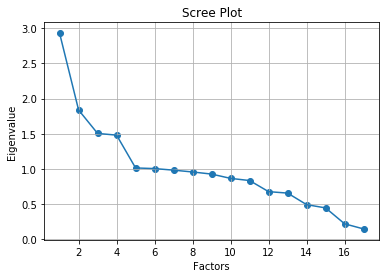

                          Factor0   Factor1   Factor2   Factor3   Factor4  \
education_content_count  0.194403  0.102071 -0.006301 -0.069837  0.789824   
media_content_count      0.629268 -0.051363  0.001672  0.022875  0.097041   
politics_content_count   0.461172 -0.033184  0.002980  0.024219 -0.022920   
bio_language             0.016073 -0.106766 -0.011227 -0.022674 -0.009899   
community               -0.059487  1.010338 -0.028827 -0.014490  0.026613   
followers_count          0.004610 -0.010822  0.506396 -0.003341 -0.005600   
is_art                  -0.007936  0.023469  0.011416 -0.070285 -0.007096   
is_education            -0.021467  0.064456  0.009909 -0.036494  0.050250   
is_feminist             -0.001272  0.010670  0.000691  0.003676 -0.006428   
is_media                -0.001196  0.033918  0.008656  0.138226  0.009899   
is_politics              0.091952  0.018371 -0.006492  0.983690 -0.078847   
is_sports               -0.005368 -0.008682 -0.002248  0.024492  0.000433   

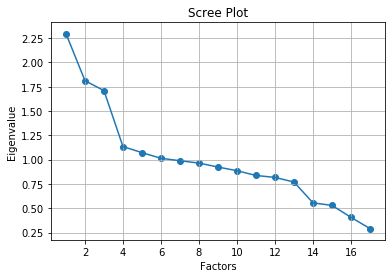

                          Factor0   Factor1   Factor2   Factor3   Factor4  \
education_content_count -0.013683 -0.054784  0.036145  0.022545  0.552999   
media_content_count     -0.059410  0.144572  0.015264  0.000179  0.653155   
politics_content_count   0.016512 -0.003681  0.025825 -0.016081  0.408228   
bio_language             0.063923  0.036585 -0.006386  0.008816  0.004910   
community                0.759945 -0.027465  0.040475 -0.044876 -0.008757   
followers_count          0.086706 -0.027664  1.069064 -0.036540  0.117001   
is_art                   0.015082  0.012016 -0.063101 -0.036827 -0.011363   
is_education            -0.010364  0.013167 -0.054946  0.007468 -0.030163   
is_feminist              0.004668 -0.017009 -0.016030  0.003507  0.028748   
is_media                -0.018994 -0.032160  0.012769  0.361132  0.000553   
is_politics             -0.103961 -0.073473 -0.020927  0.993235  0.002089   
is_sports               -0.007278  0.034296  0.106297  0.084394 -0.028004   

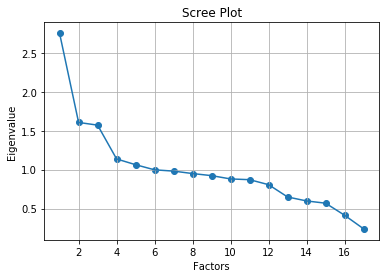

                          Factor0   Factor1   Factor2   Factor3   Factor4  \
education_content_count  0.340247  0.000448 -0.014590  0.280695  0.029827   
media_content_count      0.002437  0.025073  0.057731  0.919017  0.003803   
politics_content_count   0.476753 -0.002481 -0.040140  0.023140  0.003519   
bio_language            -0.006185 -0.026091  0.019187 -0.000107 -0.005454   
community                0.063330  0.998109  0.011943 -0.027771  0.013737   
followers_count         -0.066790  0.006560  1.011913  0.054430 -0.040686   
is_art                  -0.034466 -0.010677  0.003878  0.004099  0.126347   
is_education            -0.027621 -0.008471 -0.000812  0.003445  0.005244   
is_feminist              0.040511  0.014401 -0.007616  0.000431 -0.044508   
is_media                 0.000190 -0.052188  0.002331  0.037769  0.737509   
is_politics              0.052705 -0.032542  0.003576  0.011699  0.577649   
is_sports               -0.004109  0.029614 -0.004805 -0.015637  0.106949   

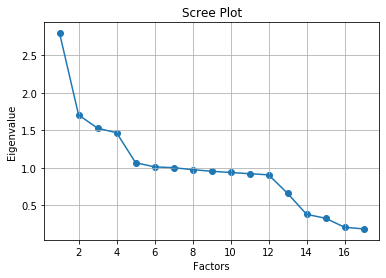

                          Factor0   Factor1   Factor2   Factor3   Factor4  \
education_content_count  0.787702 -0.085391 -0.030076  0.011245 -0.043076   
media_content_count      0.180826  0.774283  0.007412  0.024800 -0.025797   
politics_content_count  -0.145062  1.020586  0.006665 -0.011034  0.060253   
bio_language            -0.006791  0.001862  0.117994  0.000576  0.066328   
community               -0.025004  0.006927  0.690664 -0.021830 -0.024307   
followers_count          0.000801 -0.004503  0.022490  0.090829 -0.056034   
is_art                  -0.019987  0.006198 -0.011762  0.168846  0.176686   
is_education            -0.028812  0.004819 -0.021365  0.053515  0.352945   
is_feminist             -0.016511  0.004388 -0.004961 -0.018208  0.234789   
is_media                 0.034644  0.012520  0.031382  0.828425 -0.069606   
is_politics              0.011028 -0.001118 -0.019369  0.392162  0.013043   
is_sports               -0.004649 -0.000785 -0.011661  0.107405  0.020671   

In [142]:
def factor_analysis(df):
    # Create factor analysis object and perform factor analysis
    # Kaiser test choose features with eigenvalues greater than 1
    fa = FactorAnalyzer()
    fa.fit(df)
    eigen_values, vectors = fa.get_eigenvalues()
    plt.scatter(range(1,df.shape[1]+1),eigen_values)
    plt.plot(range(1,df.shape[1]+1),eigen_values)
    plt.title('Scree Plot')
    plt.xlabel('Factors')
    plt.ylabel('Eigenvalue')
    plt.grid()
    plt.show()
    
    fa = FactorAnalyzer()
    fa.set_params(n_factors = 6, rotation = "promax")
    fa.fit(df)
    loadings = fa.loadings_
    #print(fa.get_factor_variance())
    loadings = pd.DataFrame(loadings)
    loadings.index = list(df.columns)
    loadings.columns = ["Factor0","Factor1","Factor2","Factor3","Factor4","Factor5"]
    return loadings

M1_loadings = factor_analysis(M1_f)
print(M1_loadings)
M2_loadings = factor_analysis(M2_f)
print(M2_loadings)
M3_loadings = factor_analysis(M3_f)
print(M3_loadings)
M4_loadings = factor_analysis(M4_f)
print(M4_loadings)

M1_loadings.to_csv("./M1_loadings_6.csv")
M2_loadings.to_csv("./M2_loadings_6.csv")
M3_loadings.to_csv("./M3_loadings_6.csv")
M4_loadings.to_csv("./M4_loadings_6.csv")

In [ ]:
M1_users.to_csv("./M1_users.csv",index=False)
M2_users.to_csv("./M2_users.csv",index=False)
M3_users.to_csv("./M3_users.csv",index=False)
M4_users.to_csv("./M4_users.csv",index=False)

In [12]:
M1_users = pd.read_csv("./M1_users.csv")
M2_users = pd.read_csv("./M2_users.csv")
M3_users = pd.read_csv("./M3_users.csv")
M4_users = pd.read_csv("./M4_users.csv")

In [2]:
M1_users = pd.read_csv("./Orig/M1_users.csv")
M2_users = pd.read_csv("./Orig/M2_users.csv")
M3_users = pd.read_csv("./Orig/M3_users.csv")
M4_users = pd.read_csv("./Orig/M4_users.csv")

In [33]:
# Recovery code
M1_final_users = pd.read_csv("./M1_f.csv")
M2_final_users = pd.read_csv("./M2_f.csv")
M3_final_users = pd.read_csv("./M3_f.csv")
M4_final_users = pd.read_csv("./M4_f.csv")

In [61]:
M1_users.to_csv("./M1_users.csv",index=False)
M2_users.to_csv("./M2_users.csv",index=False)
M3_users.to_csv("./M3_users.csv",index=False)
M4_users.to_csv("./M4_users.csv",index=False)

In [159]:
M1_final_users.to_csv("./M1_f.csv",index=False)
M2_final_users.to_csv("./M2_f.csv",index=False)
M3_final_users.to_csv("./M3_f.csv",index=False)
M4_final_users.to_csv("./M4_f.csv",index=False)